In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
def compute_accuracy(tn,tp, observation_count):
    return (tn+tp)/float(observation_count)

In [4]:
def read_data_files():
    df_train = pd.read_csv('../data/train.csv')
    df_test = pd.read_csv('../data/test.csv')
    return df_train, df_test

In [5]:
def get_missing_feature_list(df):
    observation_count = df.shape[0]
    feature_counts = df.count()
    missing_feature_list = []
    for idx, value in feature_counts.iteritems():
        if value != observation_count:
            missing_feature_list.append(idx)

    return missing_feature_list

In [6]:
def handle_embark_missing_values(df):
    """
    Majority of passengers embarked in Southampton
    :param df:
    :return:
    """
    df.loc[df.Embarked.isnull(), 'Embarked'] = 'S'
    return df


In [7]:
def handle_age_missing_values(df):
    """
    Replace missing age values for passengers using the average age of persons in the same passenger class.

    Presumes passenger class values = {1,2,3}
    :param df: dataframe containing samples
    :return: updated dataframe
    """
    p1_ages = df[df['Pclass'] == 1]['Age']
    p1_mean = np.mean(p1_ages)
    p2_ages = df[df['Pclass'] == 2]['Age']
    p2_mean = np.mean(p2_ages)
    p3_ages = df[df['Pclass'] == 3]['Age']
    p3_mean = np.mean(p3_ages)

    df.loc[(df.Age.isnull() & (df.Pclass == 1)), 'Age'] = p1_mean
    df.loc[(df.Age.isnull() & (df.Pclass == 2)), 'Age'] = p2_mean
    df.loc[(df.Age.isnull() & (df.Pclass == 3)), 'Age'] = p3_mean

    return df

In [8]:
def handle_fare_missing_values(df):
    p1_fares = df[df['Pclass'] == 1]['Fare']
    p1_mean = np.mean(p1_fares)
    p2_fares = df[df['Pclass'] == 2]['Fare']
    p2_mean = np.mean(p2_fares)
    p3_fares = df[df['Pclass'] == 3]['Fare']
    p3_mean = np.mean(p3_fares)

    df.loc[(df.Fare.isnull() & (df.Pclass == 1)), 'Fare'] = p1_mean
    df.loc[(df.Fare.isnull() & (df.Pclass == 2)), 'Fare'] = p2_mean
    df.loc[(df.Fare.isnull() & (df.Pclass == 3)), 'Fare'] = p3_mean

    return df

In [9]:
def handle_cabin_missing_values(df):

    def truncate_cabin_name(x):
        try:
            return x[0]
        except TypeError:
            return 'None'

    df['Cabin'] = df.Cabin.apply(truncate_cabin_name)
    return df

In [10]:
def handle_missing_features(missing_features, df):
    if len(missing_features) == 0:
        return df

    feature_handlers = {'Age': handle_age_missing_values,
                        'Fare': handle_fare_missing_values,
                        'Embarked': handle_embark_missing_values,
                        'Cabin': handle_cabin_missing_values}

    for feature in missing_features:
        print("Feature missing data:", feature)
        if feature in feature_handlers:
            handler = feature_handlers[feature]
            df = handler(df)
    return df

In [45]:
def process_training_data(df_train):
    missing_features = get_missing_feature_list(df_train)
    df_train = handle_missing_features(missing_features, df_train)
    # replace Sex attribute with numeric encoding
    df_train = pd.get_dummies(df_train, columns=['Sex'], drop_first=True)
    y_predict = df_train['Survived']

    # Drop PassengerId, Survived, Name and Ticket features for use in model
    predict_features = df_train.drop(['PassengerId', 'Survived', 'Name', 'Ticket','Cabin','Embarked','SibSp','Parch'], axis=1)
    
    
    print("Predict Features", predict_features.columns)

    train_X, val_X, train_y, val_y = train_test_split(predict_features, y_predict,  random_state=0)
    tree_count = 100
    rf_classifier = RandomForestClassifier(tree_count, n_jobs=-1, max_features=None,
                                           min_samples_leaf=1, bootstrap=True, random_state=42)
    rf_classifier.fit(train_X, train_y)
    score = rf_classifier.score(train_X, train_y)
    print("Training Model Score= ", score)
    survivor_predictions = rf_classifier.predict(val_X)
    print(confusion_matrix(val_y, survivor_predictions))
    tn, fp, fn, tp = confusion_matrix(val_y, survivor_predictions).ravel()
    training_accuracy = compute_accuracy(tn, tp, val_X.shape[0])
    print("Training accuracy =", training_accuracy)
    training_records = df_train.loc[val_X.index.values]
    passengerIds = training_records['PassengerId']

    result = pd.DataFrame()
    result['PassengerId'] = passengerIds
    result['Survived'] = val_y
    result['Prediction'] = survivor_predictions

    return rf_classifier, predict_features, result

In [12]:
def process_test_data(df_test, rf_classifier, training_features):
    # Predict survivors using test data
    missing_features = get_missing_feature_list(df_test)

    df_test = handle_missing_features(missing_features, df_test)
    # replace categorical features with numeric encoding
    df_test = pd.get_dummies(df_test, columns=['Sex', 'Embarked', 'Cabin'], drop_first=True)
    # Drop PassengerId, Name and Ticket features for use in model
    predict_features = df_test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

    # Ensure training features and test features match.
    # The issue is that test data may not have a specific instance for a categorical feature that
    # has been represented as a dummy
    test_features = list(predict_features)
    missing_features = list(set(training_features).difference(test_features))
    for feature in missing_features:
        predict_features[feature] = 0

    test_predictions = rf_classifier.predict(predict_features)

    passenger_ids = df_test['PassengerId']
    print(type(test_predictions), test_predictions.shape)
    result = pd.DataFrame(passenger_ids)
    result['Survived'] = test_predictions

    # result.to_csv('../results/test_results.csv', encoding='utf-8', index=False)
    

In [14]:
df_train, df_test = read_data_files()
rf_classifier, rf_training_features, rf_results = process_training_data(df_train)

df = pd.DataFrame()
df['PassengerId'] = rf_results['PassengerId']
df['Survived'] = rf_results['Survived']
df['RF_Predict'] = rf_results['Prediction']

# re-read the data
df_train, df_test = read_data_files()

errors = df.query('Survived != RF_Predict')
false_positives = errors.loc[errors['RF_Predict'] == 1]['PassengerId']
list_false_positive_ids = false_positives.tolist()
false_positive_passengers = df_train[df_train['PassengerId'].isin(list_false_positive_ids)]
false_positive_passengers_export = false_positive_passengers[['PassengerId','Survived','Pclass','Age','Sex','SibSp','Parch',
                                                            'Fare','Cabin','Embarked']]
false_positive_passengers_export.to_csv('../results/false_positive_rf_predictions.csv',encoding='utf-8', index=False)

false_negatives = errors.loc[errors['RF_Predict'] == 0]['PassengerId']
list_false_negative_ids = false_negatives.tolist()
false_negative_passengers = df_train[df_train['PassengerId'].isin(list_false_negative_ids)]
false_negative_passengers_export = false_negative_passengers[['PassengerId','Survived','Pclass','Age','Sex','SibSp','Parch',
                                                            'Fare','Cabin','Embarked']]
false_negative_passengers_export.to_csv('../results/false_negative_rf_predictions.csv',encoding='utf-8', index=False)


correct_predictions = df.query('Survived == RF_Predict')
correct_passenger_ids = correct_predictions['PassengerId']
list_correct_predictions = correct_passenger_ids.tolist()
correct_passengers = df_train[df_train['PassengerId'].isin(list_correct_predictions)]

correct_passengers_export = correct_passengers[['PassengerId','Survived','Pclass','Age','Sex','SibSp','Parch',
                                                            'Fare','Cabin','Embarked']]

correct_passengers_export.to_csv('../results/correct_rf_predictions.csv',encoding='utf-8', index=False)


Feature missing data: Age
Feature missing data: Cabin
Feature missing data: Embarked
Model score=  0.9865269461077845
[[126  13]
 [ 19  65]]
Training accuracy = 0.8565022421524664


In [16]:
df_train[df_train['PassengerId'].isin([268,705])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
267,268,1,3,"Persson, Mr. Ernst Ulrik",male,25.0,1,0,347083,7.7750,NaN,S
704,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S


In [ ]:
sns.jointplot(x='total_bill',y='tip',data=tips,kind='scatter')

In [47]:
def join_feature_name_with_importance_value(features, importances):
    '''
    Join via a list of tuples, feature names with their importance values
    :param features: data frame whose features are represented by columns used by classifier
    :param importances: feature importance scores assigned by classifier
    :return: sorted list (highest importances first) of feature,importance tuples
    '''
    if features.columns.shape[0] != importances.shape[0]:
        return []

    feature_importances = []
    for item in range(features.columns.shape[0]):
        feature_importances.append((features.columns[item], importances[item]))
    feature_importances_sorted = sorted(feature_importances, reverse=True, key=lambda kv: kv[1])

    return feature_importances_sorted

Feature missing data: Age
Feature missing data: Cabin
Feature missing data: Embarked
Predict Features Index(['Pclass', 'Age', 'Fare', 'Sex_male'], dtype='object')
Training Model Score=  0.9775449101796407
[[124  15]
 [ 28  56]]
Training accuracy = 0.8071748878923767
Feature ranking:
Feature:  Sex_male 0.31532461882593876
Feature:  Fare 0.3066756267955963
Feature:  Age 0.2804070575279088
Feature:  Pclass 0.09759269685055622


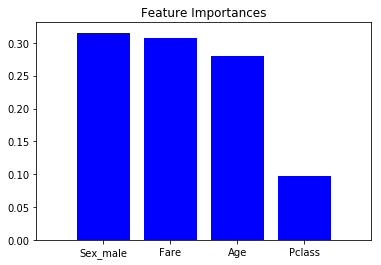

In [57]:
import matplotlib.pyplot as plt

df_train, df_test = read_data_files()
rf_classifier, rf_training_features, rf_results = process_training_data(df_train)
training_features_list = list(rf_training_features)
importances = rf_classifier.feature_importances_
feature_importances = join_feature_name_with_importance_value(rf_training_features, importances)


# Print the feature ranking
print("Feature ranking:")

for f in feature_importances:
    print("Feature: ",f[0], f[1])
   
 
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), [x[1] for x in feature_importances],
       color="b",  align="center")
plt.xticks(range(len(feature_importances)),[x[0] for x in feature_importances])
plt.xlim([-1, len(feature_importances)])
plt.show()